# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [1]:
import csv
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

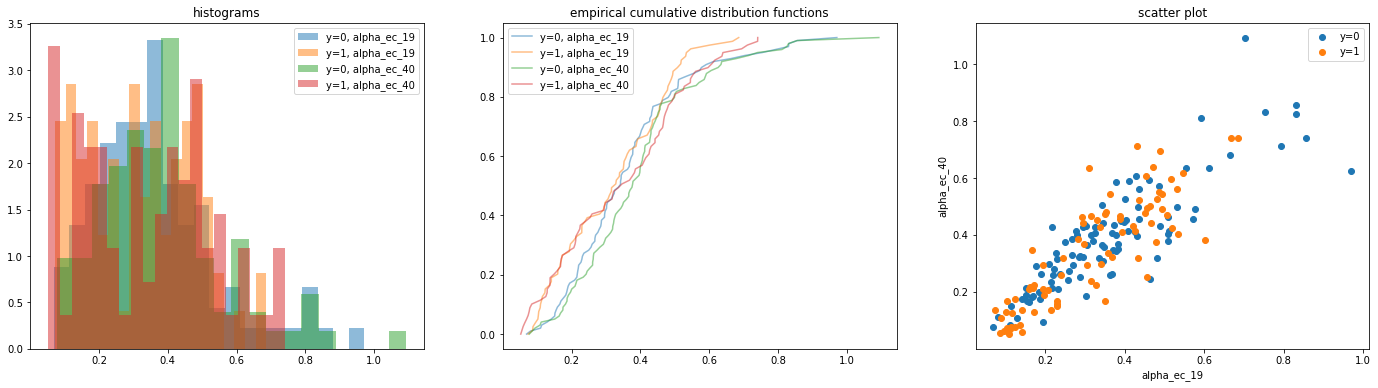

In [3]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
#i0, i1 = np.random.randint(0, X.shape[1], size=2)

#same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
f = np.random.randint(0, num_features)
e0, e1 = np.random.randint(0, num_electrodes, size=2)
i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

In [4]:
print(X[:, 0].shape)

(180,)


In [5]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


In [6]:
#computing pearson correlation
pearson_correlation=[]
from scipy.stats import pearsonr
for i in range(X.shape[1]):
    corr, _ =pearsonr(X[:,i], y)
    pearson_correlation.insert(i,corr)

pearson_correlation=np.array(pearson_correlation)
feature_names=np.array(feature_names)

In [7]:
indices = np.argsort(-1*pearson_correlation)# array containing indices wrt to descending order
pearson_correlation=pearson_correlation[indices]
featuresnames_sorted=feature_names[indices]

In [8]:
#making a dictionary of feature name  with its pearson correlation
featurename_correlation={}
for i in range(0,len(feature_names)):
    featurename_correlation[feature_names[indices[i]]]=pearson_correlation[i]

In [9]:
#featurename_correlation

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


In [11]:
def make_trainingmatrix(columns): # The np.hstack function can be very helpful
    training_set=np.array(X[:,indices[0]])
    if(columns==0):
        return(training_set.T[training_set.T.astype('int64'),None])
    if(columns>0):
        for i in range(1,columns+1): 
            training_set = np.vstack((training_set,X[:,indices[i]]))
    return(training_set.T) 

In [12]:
t=make_trainingmatrix(0)
t.shape

(180, 1)

Text(0, 0.5, 'Log Loss')

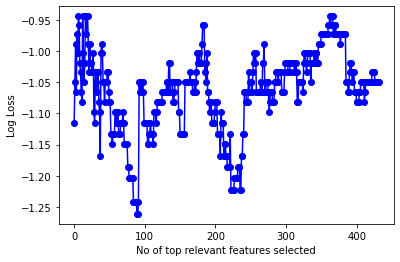

In [13]:
#selecting top relevant features using Cross Validation
from sklearn.model_selection import KFold 
cv = KFold(n_splits = 10) # 
n_neighbors = 11
reg= KNeighborsClassifier(n_neighbors)
all_loss = []
for i in range(0,432):  # 1st for loop over polynomial orders 
    X_train = make_trainingmatrix(i)
    loss_at_order = []
    for train_index, test_index in cv.split(X_train): # 2nd for loop for cross-validation
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        t_train_cv, t_test_cv = y[train_index], y[test_index] 
        reg.fit( X_train_cv,t_train_cv)
        loss_at_order.append( np.mean(( t_test_cv - reg.predict(X_test_cv) )**2  ) ) # collect loss at fold
    all_loss.append(np.mean(loss_at_order)) # collect loss at order
plt.plot(np.log(all_loss), 'bo-') # plot log(loss) at order
plt.xlabel('No of top relevant features selected') # always label x&y-axis
plt.ylabel('Log Loss') # always label x&y-axis




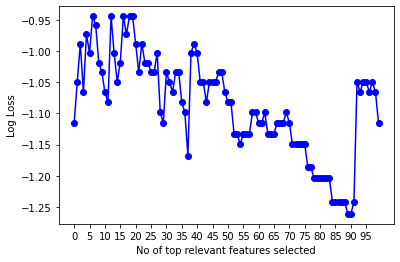

In [14]:
#for clarity purpose have picked top 100 relevant featues to have to a clear picture of how many top features given lowest error
losses = np.log(all_loss)
x=np.arange(0,100,5)
plt.plot(losses[0:100], 'bo-') # plot log(loss) at order
plt.xlabel('No of top relevant features selected') # always label x&y-axis
plt.ylabel('Log Loss') # always label x&y-axis
plt.xticks(x)
plt.show()


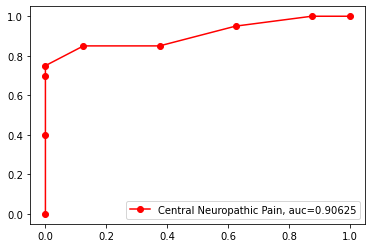

In [15]:
#selecting top 90 features based on lowest error using test train split
from sklearn.model_selection import train_test_split
from sklearn import metrics
Updated_data_90 = make_trainingmatrix(90)# selecting top 90 features
X_train, X_test, y_train, y_test = train_test_split(Updated_data_90,y,test_size=0.20, random_state=123)
clf1 = reg.fit(X_train, y_train)
y_pred1 = clf1.predict(X_test)
y_pred_proba1 = clf1.predict_proba(X_test)[:,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba1)
plt.plot(fpr1,tpr1,'ro-',label="Central Neuropathic Pain, auc="+str(auc1))
plt.legend(loc=4)
plt.show()


In [16]:
#accuracy using confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)
print("confusion matrix")
print(cm)
sum = 0
for i in range(cm.shape[0]):
    sum += cm[i][i]
    
accuracy = sum/X_test.shape[0]
print("accuracy",accuracy)

confusion matrix
[[16  0]
 [ 6 14]]
accuracy 0.8333333333333334


In [17]:
#using cross validation for measuring loss across folds
X_train1 = make_trainingmatrix(90)# selecting top 90 features
loss = []
cv = KFold(n_splits = 10)
for train_index, test_index in cv.split(X_train1): # 2nd for loop for cross-validation
        print('TRAIN:', train_index, 'TEST:', test_index)
        X_train_cv, X_test_cv = X_train1[train_index], X_train1[test_index]
        t_train_cv, t_test_cv = y[train_index], y[test_index] 
        reg.fit(X_train_cv, t_train_cv) # fit a model on the training data 
        loss.append( np.mean(( t_test_cv - reg.predict(X_test_cv) )**2  ) ) # compute loss on test data
print("loss across folds",loss) # print loss across fold
print("mean loss",np.mean(loss)) # print average loss these number of Folds


TRAIN: [ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  8

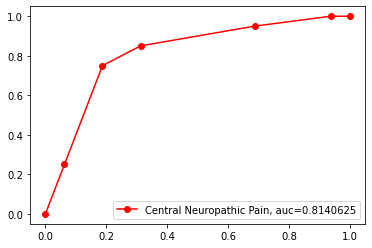

In [35]:
# selecting all the 432 features to compare accuracy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)
clf1 = reg.fit(X_train, y_train)
y_pred1 = clf1.predict(X_test)
y_pred_proba1 = clf1.predict_proba(X_test)[:,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba1)
plt.plot(fpr1,tpr1,'ro-',label="Central Neuropathic Pain, auc="+str(auc1))
plt.legend(loc=4)
plt.show()

In [36]:
# selecting all the 432 features to compare accuracy
cv = KFold(n_splits = 10)
for train_index, test_index in cv.split(X): # 2nd for loop for cross-validation
        print('TRAIN:', train_index, 'TEST:', test_index)
        X_train_cv, X_test_cv = X_train1[train_index], X_train1[test_index]
        t_train_cv, t_test_cv = y[train_index], y[test_index] 
        reg.fit(X_train_cv, t_train_cv) # fit a model on the training data 
        loss.append( np.mean(( t_test_cv - reg.predict(X_test_cv) )**2  ) ) # compute loss on test data
print("loss across folds",loss) # print loss across fold
print("mean loss",np.mean(loss)) # print average loss these number of Folds


TRAIN: [ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  8

In [37]:
#accuracy using confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)
print("confusion matrix")
print(cm)
sum = 0
for i in range(cm.shape[0]):
    sum += cm[i][i]
    
accuracy = sum/X_test.shape[0]
print("accuracy",accuracy)

confusion matrix
[[14  2]
 [10 10]]
accuracy 0.6666666666666666


In [60]:
#feature selection using Chi-Square

from sklearn.feature_selection import SelectKBest, chi2
X_Chi_Square = SelectKBest(chi2, k=90).fit_transform(X, y)
X_Chi_Square.shape

(180, 90)

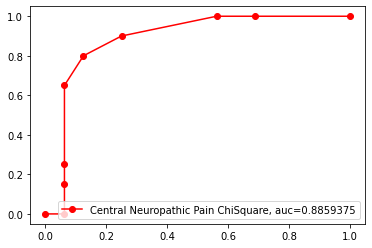

In [61]:
#computing roc,auc based on Chi_Square 
Updated_data= X_Chi_Square
X_train, X_test, y_train, y_test = train_test_split(Updated_data,y,test_size=0.20, random_state=123)
clf1 = reg.fit(X_train, y_train)
y_pred1 = clf1.predict(X_test)
y_pred_proba1 = clf1.predict_proba(X_test)[:,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba1)
plt.plot(fpr1,tpr1,'ro-',label="Central Neuropathic Pain ChiSquare, auc="+str(auc1))
plt.legend(loc=4)
plt.show()


In [20]:
#using cross validation for measuring loss across folds with Chi-Square as a statistical measure
X_train1 = Updated_data# selecting top 90 features
loss = []
cv = KFold(n_splits = 10)
for train_index, test_index in cv.split(X_train1): # 2nd for loop for cross-validation
        print('TRAIN:', train_index, 'TEST:', test_index)
        X_train_cv, X_test_cv = X_train1[train_index], X_train1[test_index]
        t_train_cv, t_test_cv = y[train_index], y[test_index] 
        reg.fit(X_train_cv, t_train_cv) # fit a model on the training data 
        loss.append( np.mean(( t_test_cv - reg.predict(X_test_cv) )**2  ) ) # compute loss on test data
print("loss across folds",loss) # print loss across fold
print("mean loss",np.mean(loss)) # print average loss these number of Folds


TRAIN: [ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  8

In [21]:
#accuracy using confusion matrix for Chi_Square
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)
print("confusion matrix")
print(cm)
sum = 0
for i in range(cm.shape[0]):
    sum += cm[i][i]
    
accuracy = sum/X_test.shape[0]
print("accuracy",accuracy)

confusion matrix
[[15  1]
 [ 7 13]]
accuracy 0.7777777777777778


In [22]:
#selecting features ANOVA
from sklearn.feature_selection import SelectKBest, f_classif
X_Anova = SelectKBest(f_classif, k=90).fit_transform(X, y)
X_Anova.shape

(180, 90)

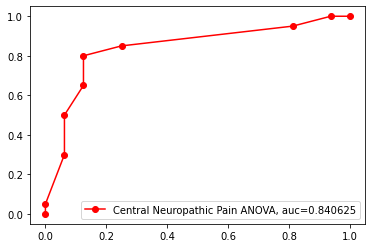

In [31]:
#computing roc,auc based on ANOVA 
Updated_data= X_Anova
X_train, X_test, y_train, y_test = train_test_split(Updated_data,y,test_size=0.20, random_state=123)
clf1 = reg.fit(X_train, y_train)
y_pred1 = clf1.predict(X_test)
y_pred_proba1 = clf1.predict_proba(X_test)[:,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba1)
plt.plot(fpr1,tpr1,'ro-',label="Central Neuropathic Pain ANOVA, auc="+str(auc1))
plt.legend(loc=4)
plt.show()


In [24]:
#accuracy using confusion matrix for Anova
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)
print("confusion matrix")
print(cm)
sum = 0
for i in range(cm.shape[0]):
    sum += cm[i][i]
    
accuracy = sum/X_test.shape[0]
print("accuracy",accuracy)

confusion matrix
[[15  1]
 [10 10]]
accuracy 0.6944444444444444


In [25]:
#using cross validation for measuring loss across folds with ANOVA as a statistical measure
X_train1 = X_Anova# selecting top 90 features
loss = []
cv = KFold(n_splits = 10)
for train_index, test_index in cv.split(X_train1): # 2nd for loop for cross-validation
        print('TRAIN:', train_index, 'TEST:', test_index)
        X_train_cv, X_test_cv = X_train1[train_index], X_train1[test_index]
        t_train_cv, t_test_cv = y[train_index], y[test_index] 
        reg.fit(X_train_cv, t_train_cv) # fit a model on the training data 
        loss.append( np.mean(( t_test_cv - reg.predict(X_test_cv) )**2  ) ) # compute loss on test data
print("loss across folds",loss) # print loss across fold
print("mean loss",np.mean(loss)) # print average loss these number of Folds


TRAIN: [ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  8

In [26]:
#selecting features mutual information
from sklearn.feature_selection import SelectKBest, mutual_info_classif
X_mutual = SelectKBest(mutual_info_classif, k=90).fit_transform(X, y)
X_mutual.shape

(180, 90)

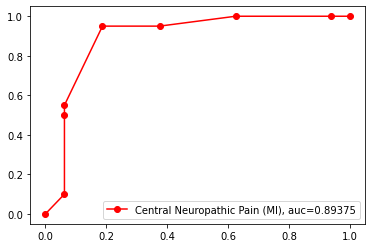

In [30]:
#computing roc,auc based on mutual information 
Updated_data= X_mutual
X_train, X_test, y_train, y_test = train_test_split(Updated_data,y,test_size=0.20, random_state=123)
clf1 = reg.fit(X_train, y_train)
y_pred1 = clf1.predict(X_test)
y_pred_proba1 = clf1.predict_proba(X_test)[:,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba1)
plt.plot(fpr1,tpr1,'ro-',label="Central Neuropathic Pain (MI), auc="+str(auc1))
plt.legend(loc=4)
plt.show()


In [28]:
#accuracy using confusion matrix for mutual information
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)
print("confusion matrix")
print(cm)
sum = 0
for i in range(cm.shape[0]):
    sum += cm[i][i]
    
accuracy = sum/X_test.shape[0]
print("accuracy",accuracy)

confusion matrix
[[15  1]
 [ 9 11]]
accuracy 0.7222222222222222


In [29]:
#using cross validation for measuring loss across folds with mutual information as a statistical measure
X_train1 = X_mutual# selecting top 90 features
loss = []
cv = KFold(n_splits = 10)
for train_index, test_index in cv.split(X_train1): # 2nd for loop for cross-validation
        print('TRAIN:', train_index, 'TEST:', test_index)
        X_train_cv, X_test_cv = X_train1[train_index], X_train1[test_index]
        t_train_cv, t_test_cv = y[train_index], y[test_index] 
        reg.fit(X_train_cv, t_train_cv) # fit a model on the training data 
        loss.append( np.mean(( t_test_cv - reg.predict(X_test_cv) )**2  ) ) # compute loss on test data
print("loss across folds",loss) # print loss across fold
print("mean loss",np.mean(loss)) # print average loss these number of Folds


TRAIN: [ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  8